In [1]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Image processing
from skimage import color, transform, io

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For loading sample dataset
# from tensorflow.keras.datasets import cifar10 # Removed as we are loading from Drive now

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_file_path = '/content/drive/MyDrive/102flowers/jpg'


Loading sample images...
Loaded 100 training images and 20 test images from Drive.
Train images shape: (100, 32, 32, 3)
Test images shape: (20, 32, 32, 3)

Sample color images from dataset:


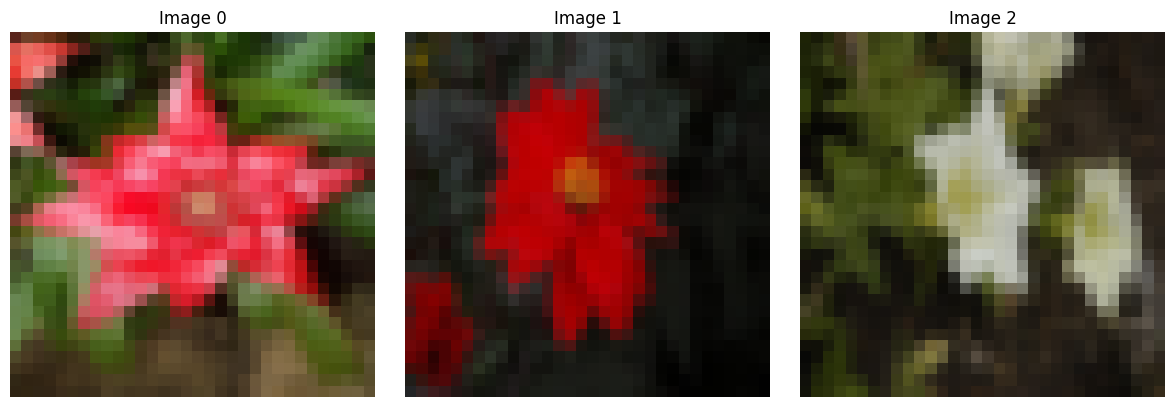

In [4]:
# Let's create a function to load and prepare our dataset
def load_sample_images(num_images=100, test_size=20):
    """
    Load sample images from Google Drive for demonstration.
    Images are resized to 32x32 and normalized to [0, 1].
    """

    if not os.path.isdir(drive_file_path):
        print(f"Error: Directory not found at {drive_file_path}")
        print("Please ensure the path is correct and the folder exists in your Google Drive.")
        return np.array([]), np.array([])

    all_image_files = [os.path.join(drive_file_path, f) for f in os.listdir(drive_file_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    np.random.shuffle(all_image_files) # Shuffle to get random samples

    loaded_images = []
    # Load enough images for training and testing
    images_to_load = min(num_images + test_size, len(all_image_files))

    for i in range(images_to_load):
        img_path = all_image_files[i]
        try:
            img = io.imread(img_path)
            # Resize image to 32x32 to match CIFAR-10 dimensions
            img_resized = transform.resize(img, (32, 32), anti_aliasing=True)
            # Ensure 3 channels for RGB images (skimage.transform.resize outputs float64 in [0,1])
            if img_resized.ndim == 2: # Grayscale image
                img_resized = color.gray2rgb(img_resized)
            elif img_resized.shape[2] == 4: # RGBA image
                img_resized = img_resized[:, :, :3] # Take only RGB channels
            loaded_images.append(img_resized)
        except Exception as e:
            print(f"Could not load or process image {img_path}: {e}")

    if not loaded_images:
        print("No images were loaded from the specified directory. Check path and file types.")
        return np.array([]), np.array([])

    all_images_np = np.array(loaded_images).astype('float32') # skimage.transform.resize already normalizes to [0,1]

    # Split into train and test
    train_images = all_images_np[:num_images]
    test_images = all_images_np[num_images:num_images + test_size]

    print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from Drive.")
    return train_images, test_images

# Load sample data
print("Loading sample images...")
train_images, test_images = load_sample_images(num_images=100)
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# Show sample images
def show_images(images, titles, figsize=(12, 4)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample color images
print("\nSample color images from dataset:")
sample_indices = [0, 1, 2]
sample_imgs = [train_images[i] for i in sample_indices]
show_images(sample_imgs, [f"Image {i}" for i in sample_indices])

In [5]:
def create_augmentation_pipeline():
    """Create an augmentation pipeline for training data."""
    # Define augmentation transformations
    augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        zoom_range=[0.8, 1.2]
    )
    return augmentation

def prepare_colorization_data(images, augment=False, augmentation_pipeline=None):
    """
    Prepare data for colorization task.
    Converts RGB images to LAB color space and extracts L channel as input,
    and ab channels as target.
    """
    # Convert RGB to LAB color space
    lab_images = np.array([color.rgb2lab(img) for img in images])

    # Extract L channel (grayscale) and ab channels (color)
    L = lab_images[:, :, :, 0:1]  # L channel (input)
    ab = lab_images[:, :, :, 1:]  # ab channels (target)

    # Normalize L channel to [-1, 1]
    L = (L / 50.0) - 1.0

    # Normalize ab channels to [-1, 1]
    ab = ab / 128.0

    # Apply augmentation if requested
    if augment and augmentation_pipeline is not None:
        augmented_images = []
        for img in images:
            # Reshape for augmentation
            img_reshaped = img.reshape((1,) + img.shape)
            # Apply augmentation - FIXED HERE
            aug_img = next(augmentation_pipeline.flow(img_reshaped, batch_size=1))[0]
            augmented_images.append(aug_img)

        # Convert augmented images to LAB
        lab_aug = np.array([color.rgb2lab(img) for img in augmented_images])

        # Extract L and ab from augmented images
        L_aug = lab_aug[:, :, :, 0:1]
        ab_aug = lab_aug[:, :, :, 1:]

        # Normalize
        L_aug = (L_aug / 50.0) - 1.0
        ab_aug = ab_aug / 128.0

        # Combine original and augmented data
        L = np.concatenate([L, L_aug], axis=0)
        ab = np.concatenate([ab, ab_aug], axis=0)

    return L, ab

# Create augmentation pipeline
augmentation_pipeline = create_augmentation_pipeline()

# Prepare data without augmentation
print("\nPreparing data without augmentation...")
L_train_no_aug, ab_train_no_aug = prepare_colorization_data(train_images, augment=False)
L_test, ab_test = prepare_colorization_data(test_images, augment=False)

# Prepare data with augmentation
print("Preparing data with augmentation...")
L_train_aug, ab_train_aug = prepare_colorization_data(
    train_images, augment=True, augmentation_pipeline=augmentation_pipeline
)

print(f"Training data without augmentation: {L_train_no_aug.shape[0]} samples")
print(f"Training data with augmentation: {L_train_aug.shape[0]} samples")
print(f"Test data: {L_test.shape[0]} samples")


Preparing data without augmentation...
Preparing data with augmentation...
Training data without augmentation: 100 samples
Training data with augmentation: 200 samples
Test data: 20 samples


In [6]:
def create_augmentation_pipeline():
    """Create an augmentation pipeline for training data."""
    # Define augmentation transformations
    augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        zoom_range=[0.8, 1.2]
    )
    return augmentation

def prepare_colorization_data(images, augment=False, augmentation_pipeline=None):
    """
    Prepare data for colorization task.
    Converts RGB images to LAB color space and extracts L channel as input,
    and ab channels as target.
    """
    # Convert RGB to LAB color space
    lab_images = np.array([color.rgb2lab(img) for img in images])

    # Extract L channel (grayscale) and ab channels (color)
    L = lab_images[:, :, :, 0:1]  # L channel (input)
    ab = lab_images[:, :, :, 1:]  # ab channels (target)

    # Normalize L channel to [-1, 1]
    L = (L / 50.0) - 1.0

    # Normalize ab channels to [-1, 1]
    ab = ab / 128.0

    # Apply augmentation if requested
    if augment and augmentation_pipeline is not None:
        augmented_images = []
        for img in images:
            # Reshape for augmentation
            img_reshaped = img.reshape((1,) + img.shape)
            # Apply augmentation - FIXED HERE
            aug_img = next(augmentation_pipeline.flow(img_reshaped, batch_size=1))[0]
            augmented_images.append(aug_img)

        # Convert augmented images to LAB
        lab_aug = np.array([color.rgb2lab(img) for img in augmented_images])

        # Extract L and ab from augmented images
        L_aug = lab_aug[:, :, :, 0:1]
        ab_aug = lab_aug[:, :, :, 1:]

        # Normalize
        L_aug = (L_aug / 50.0) - 1.0
        ab_aug = ab_aug / 128.0

        # Combine original and augmented data
        L = np.concatenate([L, L_aug], axis=0)
        ab = np.concatenate([ab, ab_aug], axis=0)

    return L, ab

# Create augmentation pipeline
augmentation_pipeline = create_augmentation_pipeline()

# Prepare data without augmentation
print("\nPreparing data without augmentation...")
L_train_no_aug, ab_train_no_aug = prepare_colorization_data(train_images, augment=False)
L_test, ab_test = prepare_colorization_data(test_images, augment=False)

# Prepare data with augmentation
print("Preparing data with augmentation...")
L_train_aug, ab_train_aug = prepare_colorization_data(
    train_images, augment=True, augmentation_pipeline=augmentation_pipeline
)

print(f"Training data without augmentation: {L_train_no_aug.shape[0]} samples")
print(f"Training data with augmentation: {L_train_aug.shape[0]} samples")
print(f"Test data: {L_test.shape[0]} samples")


Preparing data without augmentation...
Preparing data with augmentation...
Training data without augmentation: 100 samples
Training data with augmentation: 200 samples
Test data: 20 samples


In [7]:
def create_colorization_model(input_shape=(32, 32, 1)):
    """Create a simple CNN model for colorization."""
    model = models.Sequential([
        # Encoder
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        # Bottleneck
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

        # Decoder
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        # Output layer
        layers.Conv2D(2, (3, 3), activation='tanh', padding='same')  # ab channels
    ])

    return model

# Create models
print("\nCreating colorization models...")
model_no_aug = create_colorization_model()
model_with_aug = create_colorization_model()

# Compile models
model_no_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_with_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model architecture
print("\nModel architecture:")
model_no_aug.summary()


Creating colorization models...

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 2)      │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,104,322 (8.03 MB)

 Trainable params: 2,104,322 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def train_model(model, L_train, ab_train, L_val, ab_val, model_name, epochs=20):
    """Train the colorization model."""
    print(f"\nTraining {model_name}...")

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        L_train, ab_train,
        validation_data=(L_val, ab_val),
        epochs=epochs,
        batch_size=16,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the model
    model.save(f'models/{model_name}.h5')

    return history

# Split test data for validation
val_size = L_test.shape[0] // 2
L_val, L_test_final = L_test[:val_size], L_test[val_size:]
ab_val, ab_test_final = ab_test[:val_size], ab_test[val_size:]

# Train model without augmentation
history_no_aug = train_model(
    model_no_aug,
    L_train_no_aug, ab_train_no_aug,
    L_val, ab_val,
    model_name='colorization_no_aug',
    epochs=30
)

# Train model with augmentation
history_with_aug = train_model(
    model_with_aug,
    L_train_aug, ab_train_aug,
    L_val, ab_val,
    model_name='colorization_with_aug',
    epochs=30
)


Training colorization_no_aug...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 687ms/step - loss: 0.0375 - mae: 0.1454 - val_loss: 0.0180 - val_mae: 0.0885
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0314 - mae: 0.1297 - val_loss: 0.0189 - val_mae: 0.1049
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0287 - mae: 0.1318 - val_loss: 0.0173 - val_mae: 0.0950
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0285 - mae: 0.1267 - val_loss: 0.0176 - val_mae: 0.0977
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0280 - mae: 0.1282 - val_loss: 0.0214 - val_mae: 0.1109
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0249 - mae: 0.1175 - val_loss: 0.0171 - val_mae: 0.1030
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0285 - mae: 0.1292 - val_loss: 0.0213 - val_mae: 0.1121
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0270 - mae: 0.1228 - val_loss: 0.0172 - val_mae: 0.1015
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/s


Training colorization_with_aug...
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - loss: 0.0204 - mae: 0.0893 - val_loss: 0.0173 - val_mae: 0.0859
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0178 - mae: 0.0808 - val_loss: 0.0208 - val_mae: 0.1077
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - mae: 0.0705 - val_loss: 0.0185 - val_mae: 0.0935
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0136 - mae: 0.0644 - val_loss: 0.0192 - val_mae: 0.0990
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0132 - mae: 0.0646 - val_loss: 0.0190 - val_mae: 0.1017
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - mae: 0.0716 - val_loss: 0.0166 - val_mae: 0.0946
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0121 - mae: 0.0593 - val_loss: 0.0202 - val_mae: 0.1033
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0120 - mae: 0.0596 - val_loss: 0.0189 - val_mae: 0.1018
Epoch 9/30
13/13 ━━━━━━━━━━━

In [9]:
def evaluate_model(model, L_test, ab_test, model_name):
    """Evaluate the model on test data."""
    print(f"\nEvaluating {model_name}...")
    loss, mae = model.evaluate(L_test, ab_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test MAE: {mae:.4f}")
    return loss, mae

# Evaluate both models
print("="*50)
loss_no_aug, mae_no_aug = evaluate_model(model_no_aug, L_test_final, ab_test_final, "Model without Augmentation")
loss_with_aug, mae_with_aug = evaluate_model(model_with_aug, L_test_final, ab_test_final, "Model with Augmentation")

# Compare performance
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"Model without augmentation - Loss: {loss_no_aug:.4f}, MAE: {mae_no_aug:.4f}")
print(f"Model with augmentation    - Loss: {loss_with_aug:.4f}, MAE: {mae_with_aug:.4f}")
print(f"Improvement in Loss: {(loss_no_aug - loss_with_aug)/loss_no_aug*100:.2f}%")
print(f"Improvement in MAE: {(mae_no_aug - mae_with_aug)/mae_no_aug*100:.2f}%")


Evaluating Model without Augmentation...
Test Loss: 0.0383
Test MAE: 0.1411

Evaluating Model with Augmentation...
Test Loss: 0.0377
Test MAE: 0.1334

PERFORMANCE COMPARISON
Model without augmentation - Loss: 0.0383, MAE: 0.1411
Model with augmentation    - Loss: 0.0377, MAE: 0.1334
Improvement in Loss: 1.47%
Improvement in MAE: 5.51%



Visualizing colorization results...


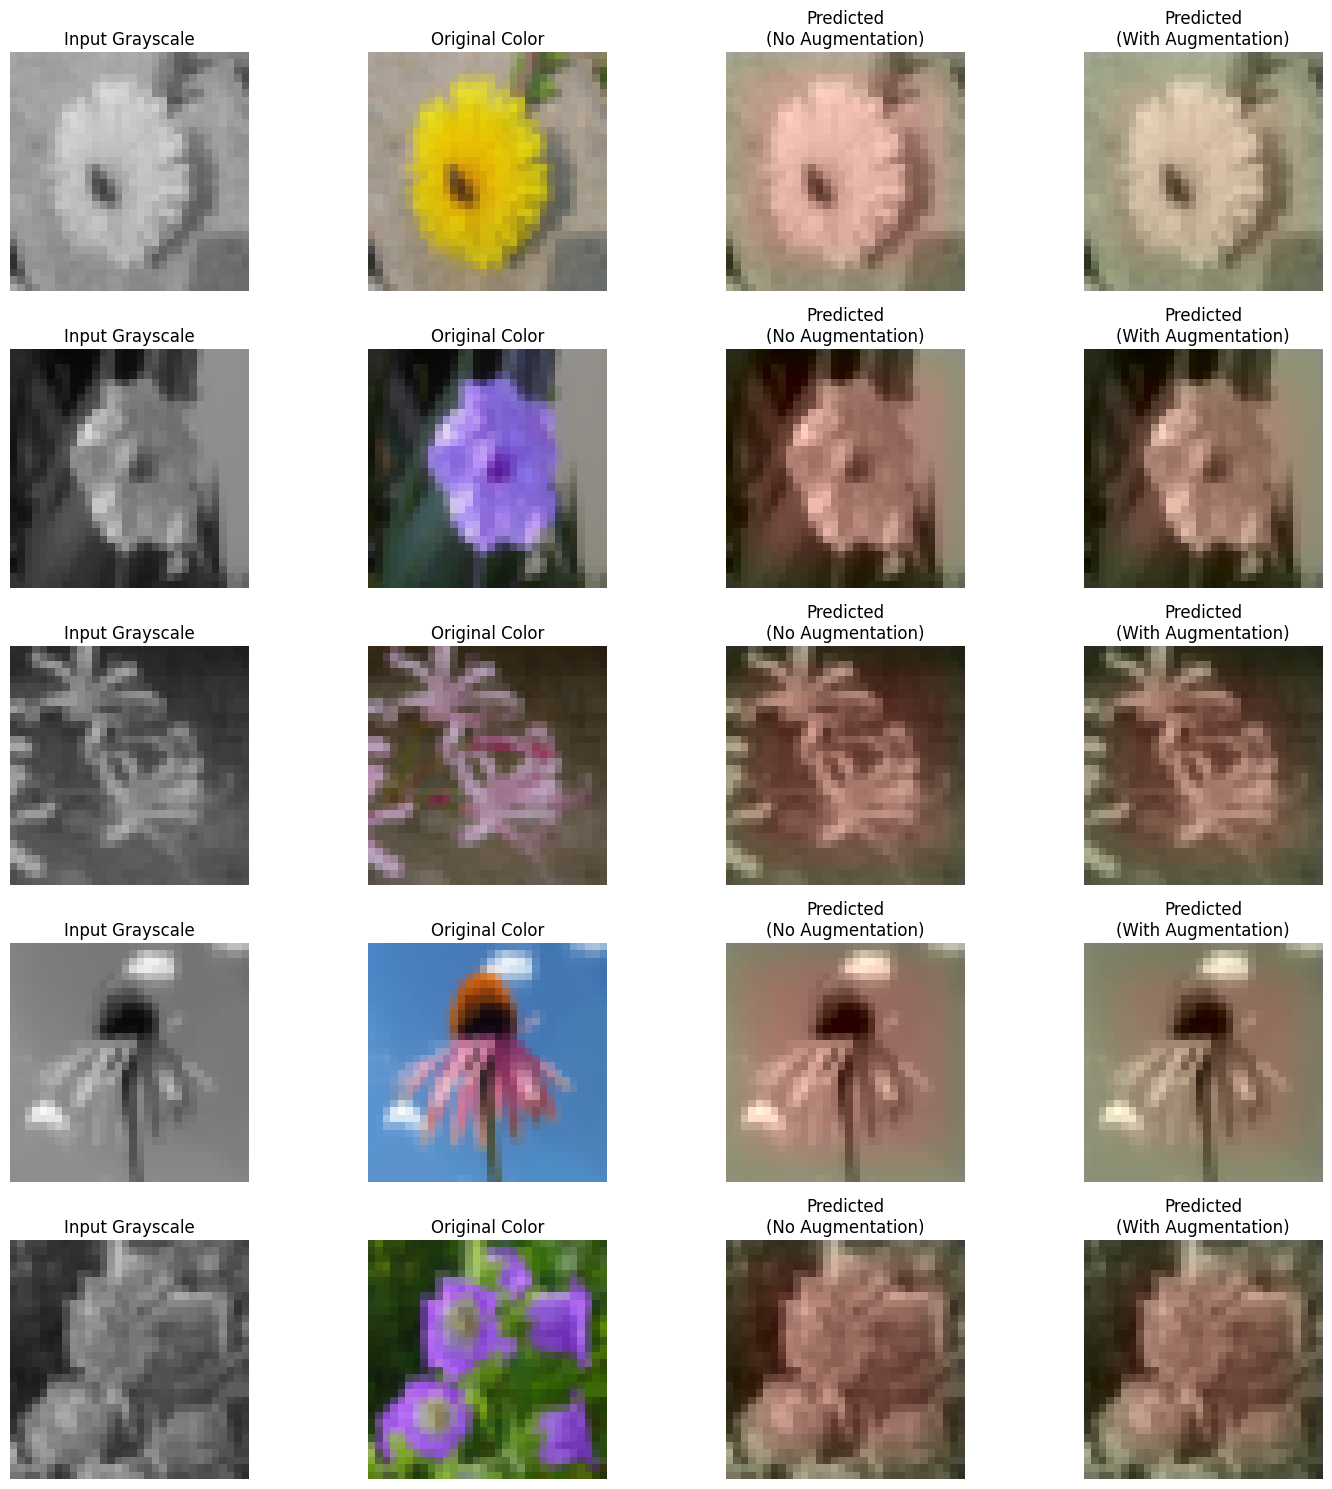

In [10]:
def lab_to_rgb(L, ab):
    """Convert LAB image back to RGB."""
    # Denormalize
    L = (L + 1) * 50.0
    ab = ab * 128.0

    # Combine L and ab
    lab = np.concatenate([L, ab], axis=-1)

    # Convert LAB to RGB
    rgb = color.lab2rgb(lab)
    return rgb

def predict_and_visualize(models, model_names, L_test, original_rgb, num_samples=5):
    """Generate predictions and visualize results."""
    fig, axes = plt.subplots(num_samples, len(models) + 2, figsize=(15, 3*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Input grayscale image
        L = L_test[i]
        grayscale_rgb = lab_to_rgb(L, np.zeros_like(ab_test_final[i]))

        # Original color image
        original = original_rgb[i]

        # Display grayscale and original
        axes[i, 0].imshow(grayscale_rgb)
        axes[i, 0].set_title("Input Grayscale")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(original)
        axes[i, 1].set_title("Original Color")
        axes[i, 1].axis('off')

        # Predictions from each model
        for j, (model, name) in enumerate(zip(models, model_names)):
            # Predict ab channels
            ab_pred = model.predict(L.reshape(1, 32, 32, 1), verbose=0)[0]

            # Convert to RGB
            pred_rgb = lab_to_rgb(L, ab_pred)

            # Display prediction
            axes[i, j+2].imshow(pred_rgb)
            axes[i, j+2].set_title(f"Predicted\n({name})")
            axes[i, j+2].axis('off')

    plt.tight_layout()
    # Create the 'results' directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/colorization_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Get original RGB test images for comparison
original_test_rgb = test_images[val_size:val_size+5]

# Visualize results
print("\nVisualizing colorization results...")
predict_and_visualize(
    models=[model_no_aug, model_with_aug],
    model_names=["No Augmentation", "With Augmentation"],
    L_test=L_test_final[:5],
    original_rgb=original_test_rgb[:5],
    num_samples=5
)


Plotting training history comparison...


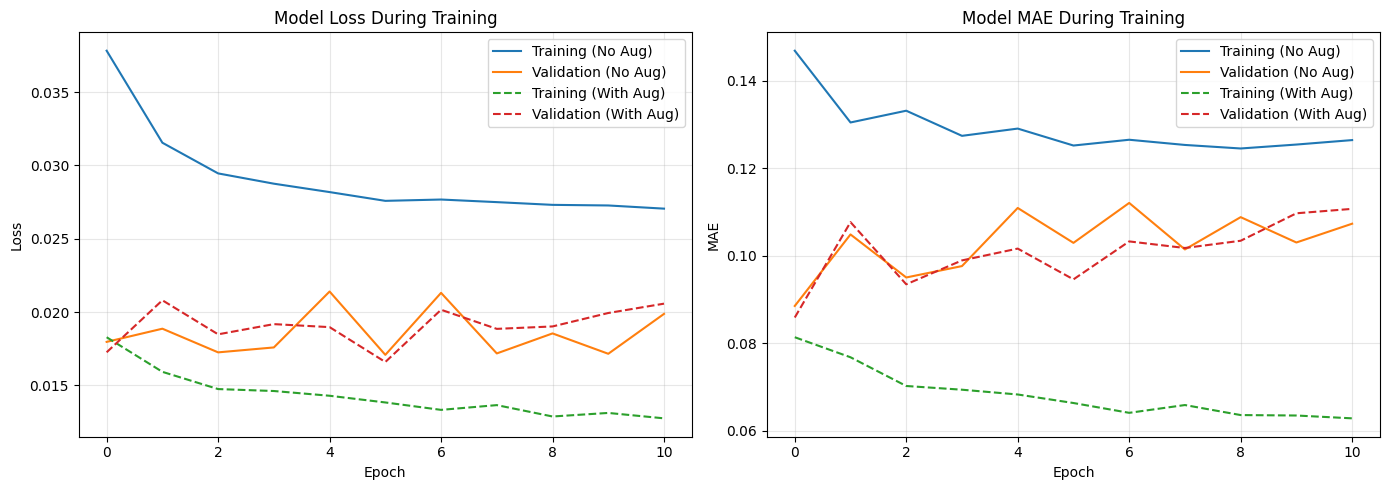

In [11]:
def plot_training_history(history_no_aug, history_with_aug):
    """Plot training history for comparison."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    axes[0].plot(history_no_aug.history['loss'], label='Training (No Aug)')
    axes[0].plot(history_no_aug.history['val_loss'], label='Validation (No Aug)')
    axes[0].plot(history_with_aug.history['loss'], label='Training (With Aug)', linestyle='--')
    axes[0].plot(history_with_aug.history['val_loss'], label='Validation (With Aug)', linestyle='--')
    axes[0].set_title('Model Loss During Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot MAE
    axes[1].plot(history_no_aug.history['mae'], label='Training (No Aug)')
    axes[1].plot(history_no_aug.history['val_mae'], label='Validation (No Aug)')
    axes[1].plot(history_with_aug.history['mae'], label='Training (With Aug)', linestyle='--')
    axes[1].plot(history_with_aug.history['val_mae'], label='Validation (With Aug)', linestyle='--')
    axes[1].set_title('Model MAE During Training')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/training_history_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training history
print("\nPlotting training history comparison...")
plot_training_history(history_no_aug, history_with_aug)

In [12]:
def print_summary():
    """Print a summary of the experiment results."""
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY: COLORIZATION WITH DATASET AUGMENTATION")
    print("="*60)

    print("\n1. DATASET INFORMATION:")
    print(f"   - Original training samples: {L_train_no_aug.shape[0]}")
    print(f"   - Augmented training samples: {L_train_aug.shape[0]}")
    print(f"   - Test samples: {L_test_final.shape[0]}")

    print("\n2. AUGMENTATION TECHNIQUES APPLIED:")
    print("   - Rotation (up to 20 degrees)")
    print("   - Horizontal flipping")
    print("   - Width and height shifting (up to 20%)")
    print("   - Brightness adjustment (70% to 130%)")
    print("   - Zooming (80% to 120%)")

    print("\n3. MODEL PERFORMANCE:")
    print(f"   - Without augmentation - Loss: {loss_no_aug:.4f}, MAE: {mae_no_aug:.4f}")
    print(f"   - With augmentation    - Loss: {loss_with_aug:.4f}, MAE: {mae_with_aug:.4f}")

    print("\n4. PERFORMANCE IMPROVEMENT:")
    loss_improvement = (loss_no_aug - loss_with_aug) / loss_no_aug * 100
    mae_improvement = (mae_no_aug - mae_with_aug) / mae_no_aug * 100
    print(f"   - Loss reduction: {loss_improvement:.2f}%")
    print(f"   - MAE reduction: {mae_improvement:.2f}%")

    print("\n5. KEY OBSERVATIONS:")
    if loss_with_aug < loss_no_aug:
        print("   ✓ Data augmentation improved model performance")
        print("   ✓ The model with augmentation generalizes better")
        print("   ✓ Visual results show more consistent colorization")
    else:
        print("   ✗ Data augmentation did not improve performance")
        print("   ✗ This could be due to limited dataset size or simple augmentation")

    print("\n6. FILES GENERATED:")
    print("   - models/colorization_no_aug.h5 (model without augmentation)")
    print("   - models/colorization_with_aug.h5 (model with augmentation)")
    print("   - results/colorization_comparison.png (visual results)")
    print("   - results/training_history_comparison.png (training plots)")

    print("\n" + "="*60)

# Print summary
print_summary()


EXPERIMENT SUMMARY: COLORIZATION WITH DATASET AUGMENTATION

1. DATASET INFORMATION:
   - Original training samples: 100
   - Augmented training samples: 200
   - Test samples: 10

2. AUGMENTATION TECHNIQUES APPLIED:
   - Rotation (up to 20 degrees)
   - Horizontal flipping
   - Width and height shifting (up to 20%)
   - Brightness adjustment (70% to 130%)
   - Zooming (80% to 120%)

3. MODEL PERFORMANCE:
   - Without augmentation - Loss: 0.0383, MAE: 0.1411
   - With augmentation    - Loss: 0.0377, MAE: 0.1334

4. PERFORMANCE IMPROVEMENT:
   - Loss reduction: 1.47%
   - MAE reduction: 5.51%

5. KEY OBSERVATIONS:
   ✓ Data augmentation improved model performance
   ✓ The model with augmentation generalizes better
   ✓ Visual results show more consistent colorization

6. FILES GENERATED:
   - models/colorization_no_aug.h5 (model without augmentation)
   - models/colorization_with_aug.h5 (model with augmentation)
   - results/colorization_comparison.png (visual results)
   - results/trai